# Online CNN training on a subspace using SMC

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
from functools import partial
from chex import ArrayDevice
from collections.abc import Callable
from tensorflow_probability.substrates import jax as tfp
from torchvision.datasets import MNIST
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

tfd = tfp.distributions

2022-09-10 11:11:56.366204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
jnp.set_printoptions(linewidth=200, suppress=True)

In [3]:
device_cpu, *_ = jax.devices("cpu")
device_tpu, *_ = jax.devices("tpu")

In [4]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [35]:
class MLP(nn.Module):
    n_hidden: int
    n_out: int
    activation: Callable[[ArrayDevice], ArrayDevice] = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
    
class SmallCNN(nn.Module):
    num_classes: int
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.tanh
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(6, kernel_size=(5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(120)(x)
        x = self.activation(x)
        x = nn.Dense(84)(x)
        x = self.activation(x)
        x = nn.Dense(self.num_classes)(x)
        # x = nn.log_softmax(x)
        return x


def smc_step(state, xs, reconstruct_fn, projection_matrix, dim_output, scale=0.1):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=scale)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs[None, ...])[:, 0, :]
    # logits = jax.vmap(model.apply, (0, None))(particles_full, xobs)
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "particles": particles_next,
        "log_target": distr_cond.log_prob(particles_next).sum(axis=1) + log_weights_next
    }
    
    return state_next, memory


def stratified_resampling(key, weights, particles):
    N = len(weights)
    u = (jnp.arange(N) + jax.random.uniform(key, (N,))) / N
    bins = jnp.cumsum(weights)
    return particles[jnp.digitize(u, bins)]


def smc_step_stratified(state, xs, reconstruct_fn, projection_matrix, dim_output, scale=0.1):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    new_particles_cond = stratified_resampling(key_resample, weights, particles_prev)
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=scale)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs[None, ...])[:, 0, :]
    # logits = jax.vmap(model.apply, (0, None))(particles_full, xobs)
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "particles": particles_next,
        "log_target": distr_cond.log_prob(particles_next).sum(axis=1) + log_weights_next,
        "log_weights": log_weights_next,
    }
    
    return state_next, memory

In [6]:
key = jax.random.PRNGKey(314)
key_sample_obs, key_weights, key_particles_init, key_smc, key_dummy, key_pm = jax.random.split(key, 6)

### Create train / test dataset

We begin by considering a classification problem over two MNIST digitis

In [21]:
n_obs = 1000

train_mask = jnp.array((mnist_train.targets == 0) | (mnist_train.targets == 1))
X_train = jnp.array(mnist_train.data)[train_mask][:n_obs]
y_train = jnp.array(mnist_train.targets)[train_mask][:n_obs]

dim_output = len(jnp.unique(y_train))

num_train, *_ = X_train.shape
# "Gaussanised" MNIST
X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_train.shape

(1000, 28, 28, 1)

## Classifying on a projected subspace

In [22]:
pca = PCA(n_components=0.9)

X_train_proj = jax.device_put(X_train.reshape(-1, 28 ** 2), device_cpu)
X_train_proj = pca.fit_transform(X_train_proj)
X_train_proj = jax.device_put(X_train_proj, device_tpu)

n_features = pca.n_components_
n_features

43

In [ ]:
%%time
n_particles = 500

model = MLP(20, dim_output)
batch = jnp.ones((1, n_features))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

dim_full = len(params_all_flat)
dim_subspace = 10

# key_pm = jax.device_put(key_pm, device_cpu) # Move pmatrix to CPU if too big to fit in TPU
# proj_matrix = jax.random.bernoulli(key_pm, p=0.5, shape=(dim_full, dim_subspace)).astype(float)
proj_matrix = jax.random.normal(key_pm, shape=(dim_full, dim_subspace))

particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))
print(proj_matrix.shape)


keys_smc = jax.random.split(key_smc, n_obs)
init_state = (log_weights_init, particles_init)
xs = (keys_smc, X_train_proj, y_ohe_train)

part_smc_step = partial(smc_step_stratified,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=dim_output,
                        scale=1.0)

(_, particles_final_sub), hist = jax.block_until_ready(jax.lax.scan(part_smc_step, init_state, xs))

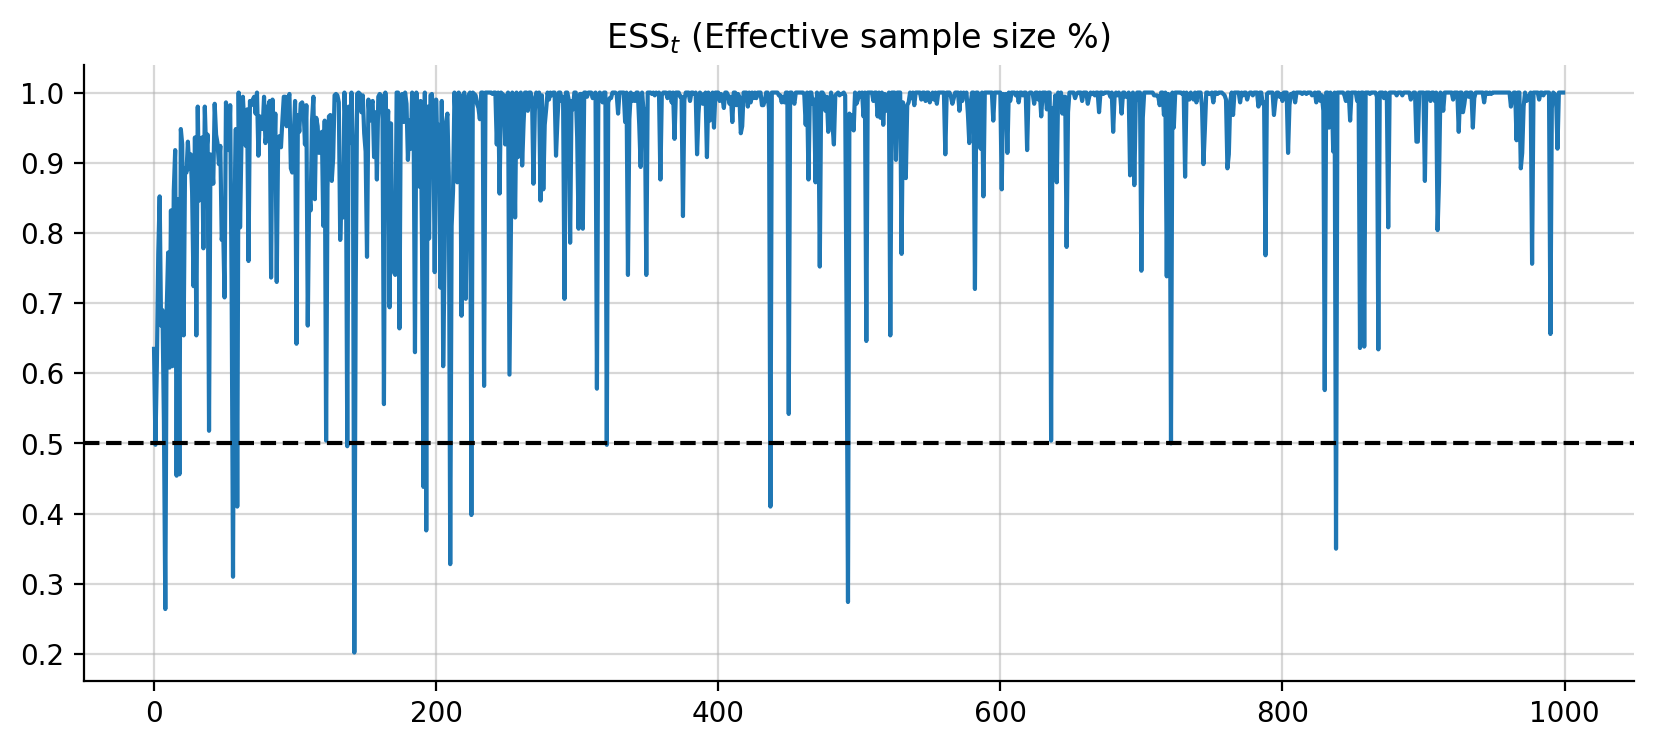

In [10]:
# Effective sample size
hist_weights = jnp.exp(hist["log_weights"] - jax.nn.logsumexp(hist["log_weights"], axis=-1, keepdims=True))
ess_hist = 1 / (hist_weights ** 2).sum(axis=-1)
ess_hist = ess_hist / n_particles

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ess_hist)
plt.grid(alpha=0.5)
plt.axhline(y=0.5, c="black", linestyle="--")
plt.title(r"ESS$_t$ (Effective sample size %)");

In [11]:
%%time 
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

particles_final = jax.device_put(particles_final, device_cpu)
X_train_cpu = jax.device_put(X_train_proj, device_cpu)

yhat_train = jax.vmap(model.apply, (0, None))(particles_final, X_train_cpu)
yhat_train = jax.nn.softmax(yhat_train)

CPU times: user 868 ms, sys: 204 ms, total: 1.07 s
Wall time: 689 ms


In [12]:
yhat_train_argmax = yhat_train.mean(axis=0).argmax(axis=-1)
confusion_matrix(y_train, yhat_train_argmax)

array([[446,  16],
       [  6, 532]])

In [13]:
(yhat_train_argmax == y_train).mean()

DeviceArray(0.97800004, dtype=float32)

#### Q: How far can we get with KNN?

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(X_train_cpu, y_train)
confusion_matrix(y_train, model.predict(X_train_cpu))

array([[462,   0],
       [  0, 538]])

In [15]:
(y_train == model.predict(X_train_cpu)).mean()

DeviceArray(1., dtype=float32)

## Classification on a $28^2$-dimensional space

In [27]:
n_particles = 1500
dim_subspace = 500

model = SmallCNN(dim_output)
batch = jnp.ones((1, 28, 28, 1))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [28]:
dim_full = len(params_all_flat)

key_pm = jax.device_put(key_pm, device_cpu) # Move pmatrix to CPU if too big to fit in TPU
proj_matrix = jax.random.normal(key_pm, shape=(dim_full, dim_subspace))

particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))

proj_matrix.shape

(151730, 500)

In [34]:
X_train.shape

(1000, 28, 28, 1)

In [36]:
%%time
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, X_train, y_ohe_train)
part_smc_step = partial(smc_step_stratified,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=dim_output)

(_, particles_final_sub), hist = jax.block_until_ready(jax.lax.scan(part_smc_step, init_state, xs))

tcmalloc: large alloc 3000000512 bytes == 0x555938a1a000 @  0x7f3502b95680 0x7f3502bb6824 0x7f3502bb6b8a 0x7f34f81afff4 0x7f34f42b092f 0x7f34f42bc30c 0x7f34f42bf9e5 0x7f34f420937a 0x7f34f3f63f68 0x7f34f3f4800b 0x555864469fc9 0x55586448ae5b 0x5558644c5c07 0x55586450988c 0x555864455ac8 0x5558644c5016 0x55586448b5d9 0x5558643a3781 0x555864469e0b 0x555864507906 0x5558644551e6 0x5558644c5016 0x55586448b5d9 0x555864577030 0x555864469db5 0x555864507906 0x5558644c4e62 0x5558645053ab 0x5558644c4e62 0x5558645053ab 0x5558644551e6
tcmalloc: large alloc 1825554432 bytes == 0x5559ec294000 @  0x7f3502b95680 0x7f3502bb6824 0x7f3502bb6b8a 0x7f34f81afff4 0x7f34f42b092f 0x7f34f42bc30c 0x7f34f42bf9e5 0x7f34f420937a 0x7f34f3f63f68 0x7f34f3f4800b 0x555864469fc9 0x55586448ae5b 0x5558644c5c07 0x55586450988c 0x555864455ac8 0x5558644c5016 0x55586448b5d9 0x5558643a3781 0x555864469e0b 0x555864507906 0x5558644551e6 0x5558644c5016 0x55586448b5d9 0x555864577030 0x555864469db5 0x555864507906 0x5558644c4e62 0x55586450

CPU times: user 1h 30min 53s, sys: 23min 36s, total: 1h 54min 29s
Wall time: 3min 35s


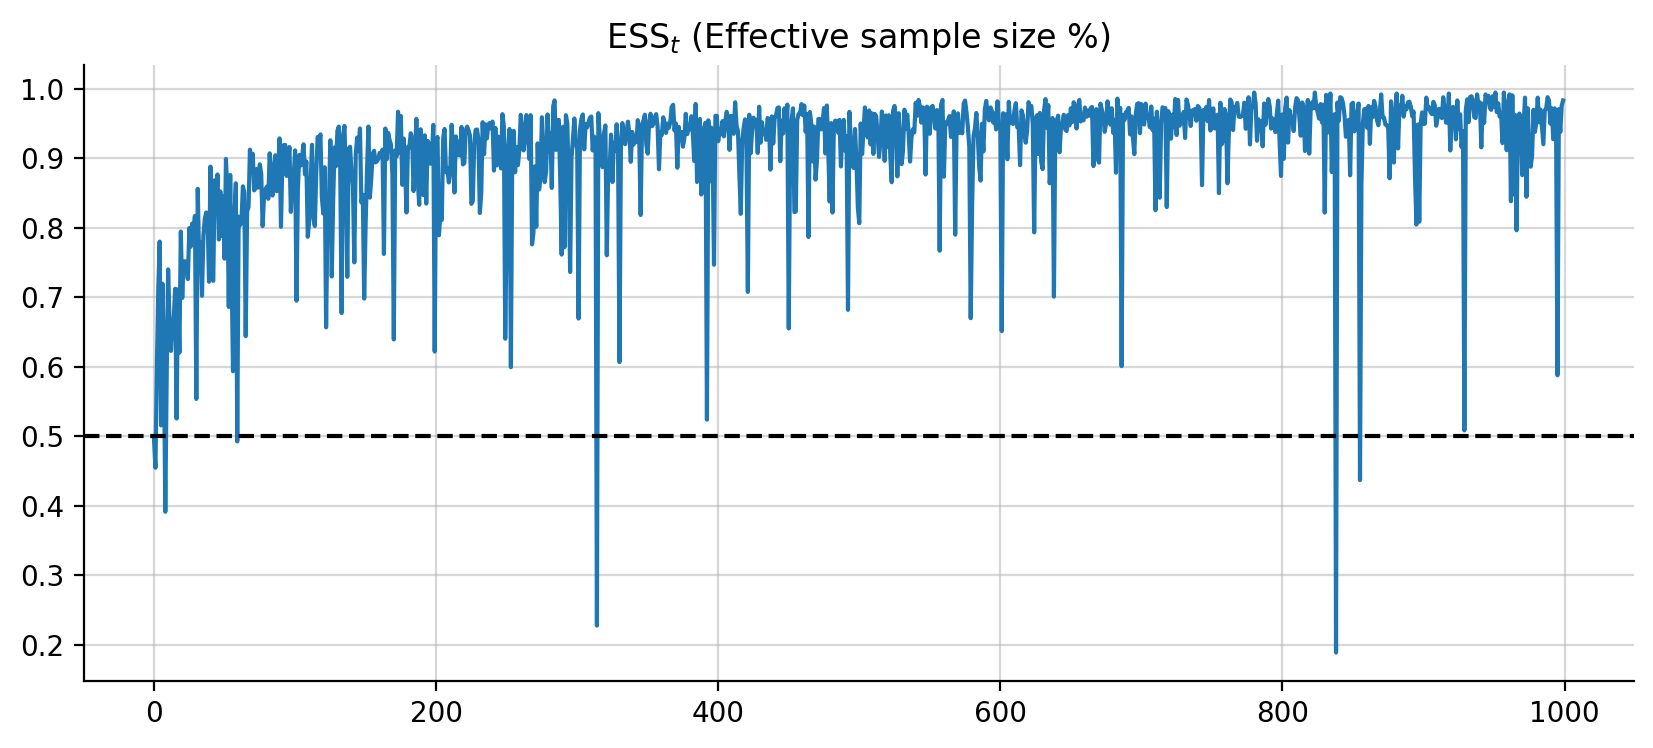

In [37]:
# Effective sample size
hist_weights = jnp.exp(hist["log_weights"] - jax.nn.logsumexp(hist["log_weights"], axis=-1, keepdims=True))
ess_hist = 1 / (hist_weights ** 2).sum(axis=-1)
ess_hist = ess_hist / n_particles

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ess_hist)
plt.grid(alpha=0.5)
plt.axhline(y=0.5, c="black", linestyle="--")
plt.title(r"ESS$_t$ (Effective sample size %)");

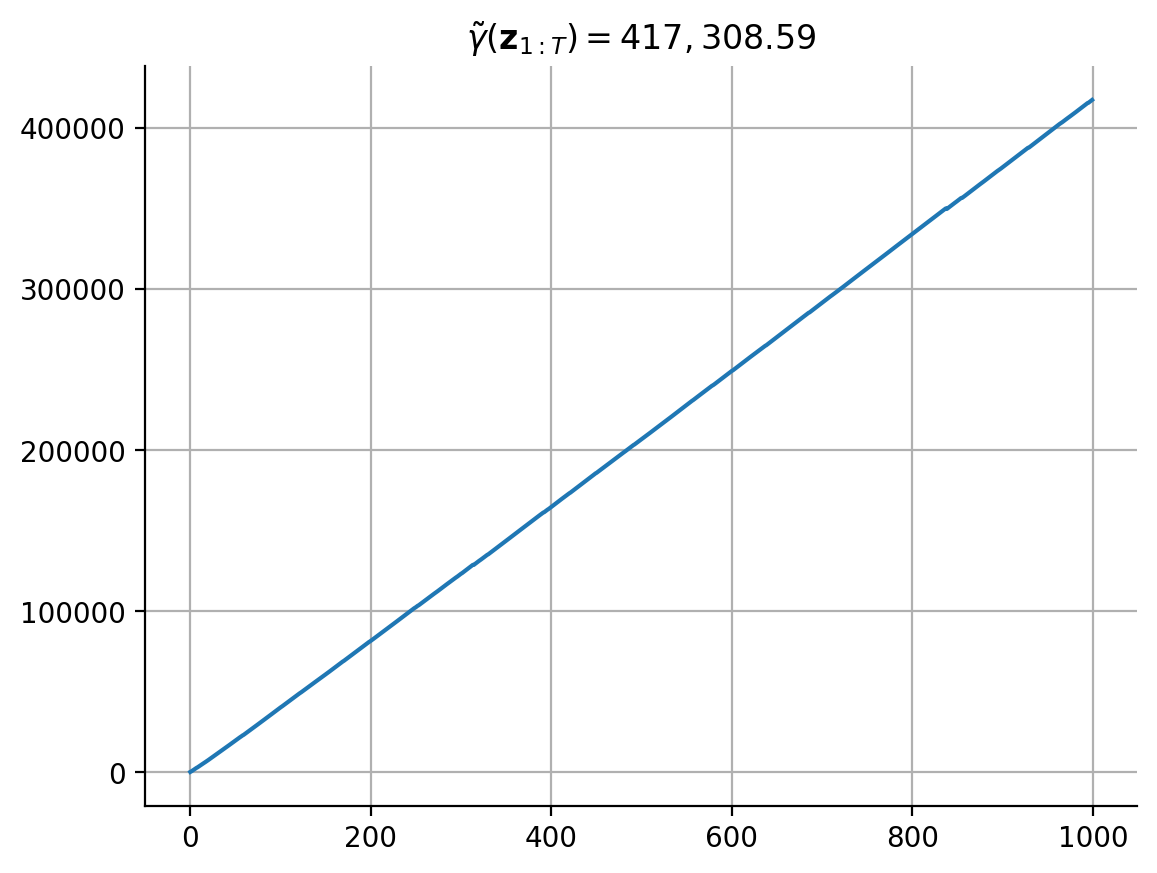

In [38]:
log_targets_hist = hist["log_target"]

# Log-unnormalised target distribution
log_utarget = log_targets_hist.sum(axis=0).mean()
plt.plot(log_targets_hist.cumsum(axis=0).mean(axis=1))
plt.title(r"$\tilde\gamma({\bf z}_{1:T})=" f"{log_utarget:,.2f}$")
plt.grid()

In [39]:
%%time 
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

particles_final = jax.device_put(particles_final, device_cpu)
X_train_cpu = jax.device_put(X_train, device_cpu)

yhat_train = jax.vmap(model.apply, (0, None))(particles_final, X_train_cpu[:500])
yhat_train = jax.nn.softmax(yhat_train)

tcmalloc: large alloc 14112006144 bytes == 0x555ab664a000 @  0x7f3502b95680 0x7f3502bb6824 0x7f3502bb6b8a 0x7f34f81afff4 0x7f34f42b092f 0x7f34f42bc30c 0x7f34f42bf9e5 0x7f34f420937a 0x7f34f3f63f68 0x7f34f3f4800b 0x555864469fc9 0x55586448ae5b 0x5558644c5c07 0x55586450988c 0x555864455ac8 0x5558644c5016 0x55586448b5d9 0x5558643a3781 0x555864469e0b 0x555864507906 0x5558644551e6 0x5558644c5016 0x555864469e0b 0x555864507906 0x5558644551e6 0x5558644c5016 0x55586448b5d9 0x555864577030 0x555864469db5 0x555864507906 0x5558644c4e62
tcmalloc: large alloc 14112006144 bytes == 0x555e0008c000 @  0x7f3502b95680 0x7f3502bb6824 0x7f34f4a1eee5 0x7f34f4aa648b 0x7f34f4aa6af9 0x7f32bf6b20a3 0x7f34f42bf9e5 0x7f34f420937a 0x7f34f3f63f68 0x7f34f3f4800b 0x555864469fc9 0x55586448ae5b 0x5558644c5c07 0x55586450988c 0x555864455ac8 0x5558644c5016 0x55586448b5d9 0x5558643a3781 0x555864469e0b 0x555864507906 0x5558644551e6 0x5558644c5016 0x555864469e0b 0x555864507906 0x5558644551e6 0x5558644c5016 0x55586448b5d9 0x555864

CPU times: user 2min 4s, sys: 3min 40s, total: 5min 44s
Wall time: 14.7 s


In [40]:
yhat_train_argmax = yhat_train.mean(axis=0).argmax(axis=-1)
confusion_matrix(y_train[:500], yhat_train_argmax)

array([[228,   1],
       [  1, 270]])

In [41]:
(yhat_train_argmax == y_train[:500]).mean()

DeviceArray(0.99600005, dtype=float32)

In [36]:
(yhat_train_argmax == y_train[:500]).mean()

DeviceArray(0.15400001, dtype=float32)